# TODO
- Traiter le cas de mots inconnus pour les word embeddings
- Optimiser dataloader
- Trouver autre dataset
- calculer sparsité
- Comparer plusieurs sparsité / autoencodeurs under/overcomplete/sans autoencodeur
- Comparer avec approche classique kmeans 
- Generer dataset syntethique couleur forme unique position variable

In [1]:
from __future__ import print_function, division

import gensim
import numpy as np
import pandas as pd
import sys, time, os, warnings 
from collections import Counter 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import torchvision.models as models

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage import io
import matplotlib.pyplot as plt
import time
import os
import copy
#import cv2
# pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.1-cp36-cp36m-win_amd64.whl
# pip3 install torchvision


C:\Users\Pierre\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Load Data

In [2]:
## The location of the train images
dir_train_jpg = "./Data/Circle_Dataset/train/images/"
## The location of the test images
dir_test_jpg = "./Data/Circle_Dataset/test/images/"
## The location of the train caption file
dir_text_train = "./data/Circle_text/circle_annotations_train.txt"
## The location of the test caption file
dir_text_test = "./data/Circle_text/circle_annotations_test.txt"


jpgs = os.listdir(dir_train_jpg)
print("The number of jpg files in train dataset: {}".format(len(jpgs)))
jpgs = os.listdir(dir_test_jpg)
print("The number of jpg files in test dataset: {}".format(len(jpgs)))

The number of jpg files in train dataset: 2000
The number of jpg files in test dataset: 200


In [3]:
## read in the Flickr caption data
def annotations_reading(dir_text):
    file = open(dir_text,'r')
    text = file.read()
    file.close()


    datatxt = []
    for line in text.split('\n'):
        col = line.split('\t')
        if len(col) == 1:
            continue
        w = col[0].split("#")
        datatxt.append(w + [col[1].lower()])


    df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])

    uni_filenames = np.unique(df_txt.filename.values)
    print("The number of unique file names : {}".format(len(uni_filenames)))
    print("The distribution of the number of captions for each image:")
    Counter(Counter(df_txt.filename.values).values())
    
    return df_txt, uni_filenames

df_txt_train, uni_filenames_train = annotations_reading(dir_text_train)
df_txt_test, uni_filenames_test = annotations_reading(dir_text_test)

The number of unique file names : 2000
The distribution of the number of captions for each image:
The number of unique file names : 200
The distribution of the number of captions for each image:


In [4]:
from keras.preprocessing.image import load_img, img_to_array

npix = 224
target_size = (npix,npix,3)

def get_random_pictures(n_pictures):
    count = 1
    fig = plt.figure(figsize=(10,20))
    for jpgfnm in uni_filenames[np.random.randint(0,uni_filenames.shape[0], size=n_pictures)]:
        filename = dir_Flickr_jpg + '/' + jpgfnm
        captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
        image_load = load_img(filename, target_size=target_size)
        
        ax = fig.add_subplot(n_pictures,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(n_pictures,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()
    
get_random_pictures(3)

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

# Sentence Processing 

In [4]:
def get_sentence_embedding(sentence, model):
    embeddings = np.array([model.word_vec(word) for word in sentence.split() if word in model.wv.vocab.keys()])
    if embeddings.ndim == 2:
        return np.sum(embeddings.T,axis=1)
    elif embeddings.ndim == 1:
        return embeddings

In [5]:
text_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300-SLIM.bin', binary=True)  

In [6]:
get_sentence_embedding('This is a test', text_model).shape

(300,)

# Image Processing 

In [7]:
image_model = models.resnet18(pretrained=True)

In [8]:
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for param in image_model.parameters():
    param.requires_grad = False
image_model = image_model.to(device)

In [9]:
plt.ion()   # interactive mode

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './Data/Circle_Dataset/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}


def classes_generation(dataset):
    
    if dataset == 'train':
        image_datasets[dataset].classes = uni_filenames_train
    elif dataset == 'test':
        image_datasets[dataset].classes = uni_filenames_test
        
    class_names = image_datasets[dataset].classes
  
    image_datasets[dataset].class_to_idx = {image_datasets[dataset].classes[i]: i for i in range(len(image_datasets[dataset].classes))}

    for i, (image, class_name) in enumerate(image_datasets[dataset].imgs):
        filename  = image_datasets[dataset].class_to_idx[image.replace('./Data/Circle_Dataset/'+dataset+'\\images\\','')]
        if dataset == 'train':
            image_datasets[dataset].imgs[i] = (image, list(df_txt_train[df_txt_train["filename"]==class_names[filename]]['caption'].values))
        elif dataset == 'test':
            image_datasets[dataset].imgs[i] = (image, list(df_txt_test[df_txt_test["filename"]==class_names[filename]]['caption'].values))

classes_generation('train')
classes_generation('test')



dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

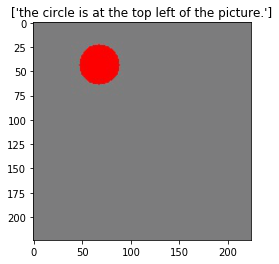

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
classes = [x[0] for x in classes]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=classes)


In [11]:
def generate_representations(dataset):
    if dataset == 'train':
        images= torch.zeros([df_txt_train.shape[0], 1000], dtype=torch.float)
        captions = torch.zeros([df_txt_train.shape[0], 300], dtype=torch.float)
    elif dataset == 'test':
        images= torch.zeros([df_txt_test.shape[0], 1000], dtype=torch.float)
        captions = torch.zeros([df_txt_test.shape[0], 300], dtype=torch.float)
        
    for i, (image, labels) in enumerate(dataloaders[dataset]):
        labels = [x[0] for x in labels]
        im = image_model(image)
        for j in range(len(labels)):
            capt = get_sentence_embedding(labels[j], text_model)
            if capt.size == 300:
                # a modifier pour ne pas sauvegarder 5x la meme image
                images[i+j] = im
                captions[i+j] = torch.from_numpy(capt)
    return images, captions

images_train, captions_train = generate_representations('train')
images_test, captions_test = generate_representations('test')

In [12]:
images_train

tensor([[-0.7802, -0.5826, -0.5586,  ..., -0.6609,  1.2589,  0.9917],
        [-0.6888, -0.3985, -0.4927,  ..., -0.5823,  1.2448,  0.9889],
        [-0.6769, -0.5025, -0.5505,  ..., -0.6794,  1.2222,  1.0452],
        ...,
        [-0.5975, -0.3889, -0.5880,  ..., -0.6137,  1.2614,  1.0577],
        [-0.7384, -0.3644, -0.5164,  ..., -0.6709,  1.1350,  0.9233],
        [-0.5678, -0.4392, -0.5963,  ..., -0.5979,  1.2612,  1.0830]])

# Sparse Autoencoder


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SparseAutoencoder(nn.Module):
    def __init__(self, n_inp, n_hidden):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(n_inp, n_hidden)
        self.decoder = nn.Linear(n_hidden, n_inp)

    def forward(self, x):
        encoded = F.relu(self.encoder(x)) # relu or sigmoid
        decoded = F.sigmoid(self.decoder(encoded))
        return encoded, decoded
    

In [13]:
# Model parameters
# BATCH_SIZE = 5 a intégrer
N_INP = 1000 + 300 # Image representation + Word2Vec
N_HIDDEN = 2000
N_EPOCHS = 30
LEARNING_RATE = 1e-3

use_kl = False

# If using KL-divergence
BETA = 3 # Importance of the KL-divergence penalty term
RHO = 0.01 # Target sparsity

if use_kl :
    rho = torch.FloatTensor([RHO for _ in range(N_HIDDEN)]).unsqueeze(0)

# If using L1 regularization
LAMBDA = 1e-5 # L1 penalty term

In [14]:
auto_encoder = SparseAutoencoder(N_INP, N_HIDDEN)
optimizer = optim.Adam(auto_encoder.parameters(), lr=LEARNING_RATE)

In [15]:
def kl_divergence(p, q):
    '''
    args:
        2 tensors `p` and `q`
    returns:
        kl divergence between the softmax of `p` and `q`
    '''
    p = F.softmax(p)
    q = F.softmax(q)

    s1 = torch.sum(p * torch.log(p / q))
    s2 = torch.sum((1 - p) * torch.log((1 - p) / (1 - q)))

    return s1 + s2

In [16]:
def l1_penalty(var):
    return torch.abs(var).sum()

In [34]:
from sklearn.manifold import TSNE
#x_embedded = TSNE(n_components=2).fit_transform(captions_train.numpy())
#print(x_embedded.shape)

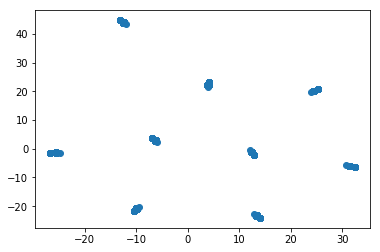

In [113]:
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])

In [17]:
def normalize(dataset):
    '''Normalization between 0 and 1'''
    for i, row in enumerate(dataset):
        min = torch.min(row)
        max = torch.max(row)
    
        dataset[i] = (row - min)/(max - min)
    return dataset

In [18]:
images_train = normalize(images_train)
# = TSNE(n_components=2).fit_transform(images_train.numpy())
#plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
#plt.show()
captions_train = normalize(captions_train)
#x_embedded = TSNE(n_components=2).fit_transform(captions_train.numpy())
#plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
#plt.show()

In [19]:
dataset = torch.cat((images_train, captions_train), 1)
#x_embedded = TSNE(n_components=2).fit_transform(dataset.numpy())
#plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
#plt.show()

In [19]:
def train(n_hidden=N_HIDDEN, l1=LAMBDA, images_train=images_train, captions_train=captions_train):
    
    auto_encoder = SparseAutoencoder(N_INP, n_hidden)
    optimizer = optim.Adam(auto_encoder.parameters(), lr=LEARNING_RATE)
    
    dataset = torch.cat((images_train, captions_train), 1)


    for epoch in range(N_EPOCHS):

        encoded, decoded = auto_encoder(dataset)

        mse_loss = F.mse_loss(decoded, dataset)

        rho_hat = torch.sum(encoded, dim=0, keepdim=True)

        if use_kl:
            sparsity_penalty = BETA * kl_divergence(rho, rho_hat)
            loss = mse_loss + sparsity_penalty
        else:
            l1_reg = l1 * l1_penalty(auto_encoder.encoder.weight)
            loss = mse_loss + l1_reg

        optimizer.zero_grad() # Clears the gradient
        loss.backward() # Computes gradient
        optimizer.step() # Update rule
        #if epoch%10 == 0:
            #print("Epoch: [%3d], Loss: %.4f" %(epoch + 1, loss.data))
            #print("Reconstruction mean squared error : ", mse_loss)
            #print("Average sparsity : ",  rho_hat.sum()/N_HIDDEN)
        
        if epoch==N_EPOCHS-1:
            print("Final MSE : ", mse_loss)
            #x_embedded = TSNE(n_components=2).fit_transform(encoded.detach().numpy())
            #plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
            #plt.show()
        
    #hist = torch.histc(auto_encoder.encoder.weight)
    #inf = torch.min(auto_encoder.encoder.weight.detach())
    #sup = torch.max(auto_encoder.encoder.weight.detach())
    #plt.plot(list(np.linspace(inf, sup, 100)), hist.detach().numpy())
    #plt.title("n_hidden : {0}, l1_reg : {1}".format(n_hidden, l1))
    #plt.show()
    return auto_encoder
auto_encoder = train()

Final MSE :  tensor(0.0006, grad_fn=<MseLossBackward>)


Final MSE :  tensor(0.0033, grad_fn=<MseLossBackward>)


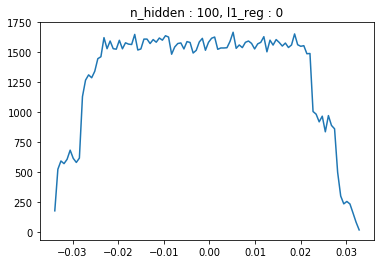

Final MSE :  tensor(0.0036, grad_fn=<MseLossBackward>)


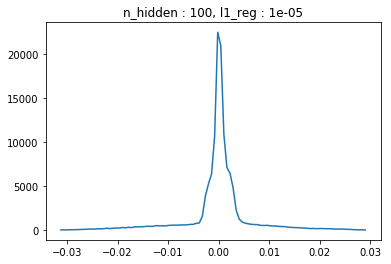

Final MSE :  tensor(0.0007, grad_fn=<MseLossBackward>)


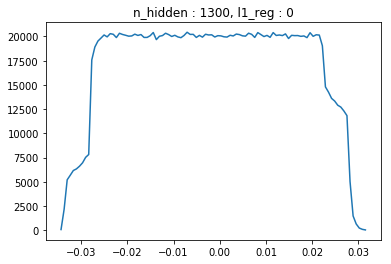

Final MSE :  tensor(0.0006, grad_fn=<MseLossBackward>)


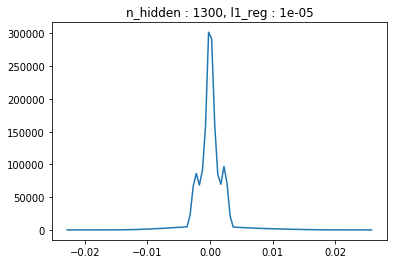

Final MSE :  tensor(0.0006, grad_fn=<MseLossBackward>)


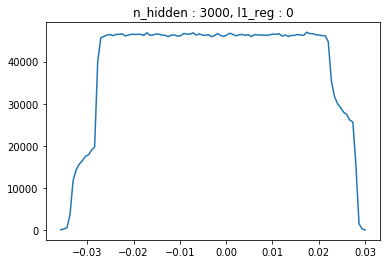

Final MSE :  tensor(0.0006, grad_fn=<MseLossBackward>)


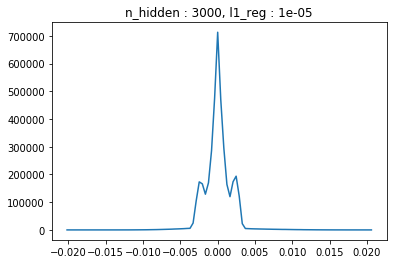

In [106]:
import itertools
for n_hidden, l1 in itertools.product([100,1300,3000],[0,1e-5]):
    train(n_hidden, l1)

tensor(-0.0348)
tensor(0.0306)
[2.0000e+00 1.6600e+02 5.0230e+03 8.3480e+03 8.8140e+03 9.6930e+03
 1.0053e+04 1.0546e+04 1.1162e+04 1.1582e+04 1.4692e+04 2.8158e+04
 2.9662e+04 3.0211e+04 3.0901e+04 3.0908e+04 3.0804e+04 3.0508e+04
 3.0539e+04 3.0440e+04 3.0569e+04 3.0851e+04 3.0873e+04 3.0729e+04
 3.0760e+04 3.0890e+04 3.0965e+04 3.0513e+04 3.0502e+04 3.0539e+04
 3.0672e+04 3.0635e+04 3.0502e+04 3.0528e+04 3.0787e+04 3.0681e+04
 3.0596e+04 3.0478e+04 3.0789e+04 3.0904e+04 3.0804e+04 3.0722e+04
 3.0572e+04 3.0740e+04 3.0563e+04 3.0832e+04 3.0917e+04 3.0835e+04
 3.0482e+04 3.0633e+04 3.0630e+04 3.0757e+04 3.0592e+04 3.0697e+04
 3.0630e+04 3.0594e+04 3.0927e+04 3.0963e+04 3.0722e+04 3.0819e+04
 3.0969e+04 3.0753e+04 3.0739e+04 3.1120e+04 3.0872e+04 3.0649e+04
 3.0611e+04 3.1015e+04 3.0898e+04 3.0808e+04 3.0908e+04 3.1084e+04
 3.0657e+04 3.0408e+04 3.0539e+04 3.0721e+04 3.0854e+04 3.0605e+04
 3.0476e+04 3.0719e+04 3.0517e+04 3.0631e+04 3.0610e+04 3.0941e+04
 3.0470e+04 3.0655e+04 3.0099e+

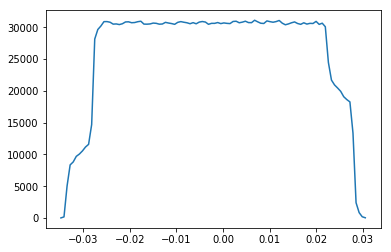

In [82]:
hist = torch.histc(auto_encoder.encoder.weight)
inf = torch.min(auto_encoder.encoder.weight.detach())
print(inf)
sup = torch.max(auto_encoder.encoder.weight.detach())
print(sup)
print(hist.detach().numpy())
plt.plot(list(np.linspace(inf, sup, 100)), hist.detach().numpy())

In [91]:
# Test

images_test = normalize(images_train) # Ou mieux de normaliser dataset après concaténation ??????
captions_test = normalize(captions_train)

dataset_test = torch.cat((images_test, captions_test), 1)

#dataset_test = normalize(dataset_test)

encoded_test, decoded_test = auto_encoder(dataset_test)
mse_loss_test = F.mse_loss(decoded_test, dataset_test)

i=0
for e in encoded[0]:
    if e > 1e-3:
        i+=1
print(i, "elements different from 0")
print("Reconstruction mean squared error on test : ", mse_loss_test)
print(dataset_test[0])
print(decoded_test[0])
print(torch.abs(dataset_test-decoded_test))
print(torch.sum(torch.abs(dataset_test-decoded_test)))
# divide by norm for percentage

983 elements different from 0
Reconstruction mean squared error on test :  tensor(0.0006, grad_fn=<MseLossBackward>)
tensor([0.3638, 0.4264, 0.3701,  ..., 0.3884, 0.5043, 0.4125])
tensor([0.3521, 0.3982, 0.3712,  ..., 0.3780, 0.4941, 0.3876],
       grad_fn=<SelectBackward>)
tensor([[0.0118, 0.0282, 0.0010,  ..., 0.0104, 0.0102, 0.0249],
        [0.0329, 0.0090, 0.0212,  ..., 0.0284, 0.0144, 0.0475],
        [0.0223, 0.0203, 0.0268,  ..., 0.0089, 0.0050, 0.0106],
        ...,
        [0.0098, 0.0073, 0.0065,  ..., 0.0039, 0.0028, 0.0350],
        [0.0195, 0.0128, 0.0123,  ..., 0.0100, 0.0101, 0.0246],
        [0.0082, 0.0001, 0.0054,  ..., 0.0119, 0.0100, 0.0262]],
       grad_fn=<AbsBackward>)
tensor(46058.9570, grad_fn=<SumBackward0>)


# Autoassociative memory - Hopfield Network - BCPNN

In [81]:
# Get autoencoder's hidden representations
x = torch.cat((images_train, captions_train), 1)
encoded, _ = auto_encoder(x)
print(type(encoded))
encoded = encoded.detach().numpy()
print(type(encoded))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


# Continuous approach

In [52]:
def calculate_weights(learning_samples, nb_hypercolumns):
    # BCPNN without hypercolumns
    hypercolumn_size = (learning_samples.shape[1]+(nb_hypercolumns-learning_samples.shape[1]%nb_hypercolumns))/nb_hypercolumns
    nb_samples = learning_samples.shape[0]
    activation_probabilities = np.sum(learning_samples, axis=0)/nb_samples # Only if patterns are only made of 0 and 1
    coactivation_probabilities = (np.transpose(learning_samples) @ learning_samples) / nb_samples
    #np.fill_diagonal(coactivation_probabilities, 0)
    
    w = np.zeros((nb_samples, nb_samples))
    
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            if i//hypercolumn_size == j//hypercolumn_size or i==j:
                w[i, j] = 0
            if activation_probabilities[i] == 0 or activation_probabilities[j] == 0:
                w[i, j] = 0 # Useless
            elif coactivation_probabilities[i, j] == 0: # Mettre un seuil à la place de 0 ?
                w[i, j] = 1/nb_samples # Cas continu ?
            else:
                w[i, j] = coactivation_probabilities[i, j]/(activation_probabilities[i]*activation_probabilities[j]) 
             
    bias = np.where(activation_probabilities == 0, 1/(nb_samples**2), activation_probabilities) # Mettre un seuil à la place de 0 ?
    
    return w, bias

In [72]:
w, bias = calculate_weights(encoded, 2)
print(w)
print(bias)

[[1.00025451 1.00020874 0.         ... 1.00007534 1.0003252  0.        ]
 [1.00020874 1.00019169 0.         ... 1.00006592 1.00027514 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [1.00007534 1.00006592 0.         ... 1.00197101 1.00046313 0.        ]
 [1.0003252  1.00027514 0.         ... 1.00046313 1.00058532 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[2.1873425e-01 3.1230190e-01 2.5000000e-07 ... 2.3178685e-02 1.2004756e-01
 2.5000000e-07]


In [73]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

2191198.8252340555
536675.1242090412
0.0


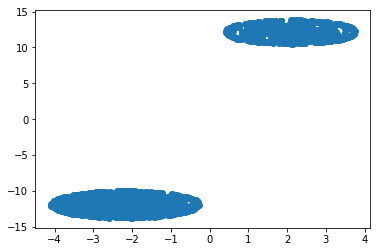

In [75]:
# Test on test set
x = encoded_test.detach().numpy()
x_before = x
for i in range(3) :
    x = np.dot(w, x) + bias
    x = sigmoid(x)
    print(np.sum(np.abs(x-x_before)))
    x_before = x
    
x_embedded = TSNE(n_components=2).fit_transform(x)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.show()

# Discrete approach

In [84]:
# Discretize the input : 1 hypercolumn per element with same number of units in each hypercolumn
# Same number of intervals for the continuous elements

nb_intervals = 5

# Do better by looking at the distribution inside the dataset
intervals = np.ones((nb_intervals+1, encoded.shape[1]))
for j in range(encoded.shape[1]):
    inf = np.min(encoded[:, j])
    sup = np.max(encoded[:, j])

    if inf != sup:
        intervals[:, j] = np.arange(inf, sup, (sup-inf)/(nb_intervals+1))
    else:
        intervals[:, j] = extrema[:, j]*sup
print(intervals[:, 0])

def discretize(x, intervals, nb_intervals):
    discrete_x = np.zeros((x.shape[0], nb_intervals*x.shape[1])) # one line is one hypercolumn
    for j in range(x.shape[1]):
        if intervals[0, j] != intervals[1, j]:
            for i, e in enumerate(x[:, j]):
                for k in range(1, intervals.shape[0]):
                    if e > intervals[k-1, j] and e < intervals[k, j]:
                        discrete_x[i, j*nb_intervals + k-1] = 1
                        break

    return discrete_x

discrete_encoded = discretize(encoded, intervals, nb_intervals)
print(discrete_encoded.shape)

[0.20840424 0.21227645 0.21614866 0.22002087 0.22389308 0.22776528]
(2000, 10000)


In [85]:
print(encoded.shape[1])
w, bias = calculate_weights(discrete_encoded, encoded.shape[1])
print(w)
print(bias)

2000
[[4.08163265e+01 5.00000000e-04 5.00000000e-04 ... 5.00000000e-04
  5.00000000e-04 5.00000000e-04]
 [5.00000000e-04 4.97512438e+00 5.00000000e-04 ... 3.50101345e-01
  2.48756219e-01 5.00000000e-04]
 [5.00000000e-04 5.00000000e-04 2.33100233e+00 ... 8.11534145e-01
  5.63325563e-01 3.04043782e-01]
 ...
 [5.00000000e-04 3.50101345e-01 8.11534145e-01 ... 7.40740741e+00
  5.00000000e-04 5.00000000e-04]
 [5.00000000e-04 2.48756219e-01 5.63325563e-01 ... 5.00000000e-04
  1.66666667e+01 5.00000000e-04]
 [5.00000000e-04 5.00000000e-04 3.04043782e-01 ... 5.00000000e-04
  5.00000000e-04 4.34782609e+01]]
[2.45e-02 2.01e-01 4.29e-01 ... 2.50e-07 2.50e-07 2.50e-07]


In [109]:
# Test on test set
x = discretize(encoded_test.detach().numpy(), intervals, nb_intervals)
print(x)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
11825110.863296663
2567223.4901285414
0.0
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


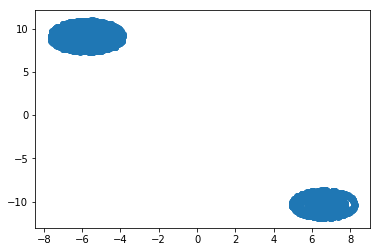

In [110]:
print(x)
x_before = x

for i in range(3):
    x = np.dot(w, x) + bias
    # Better to use softmax inside a hypercolumn than sigmoid 
    x = sigmoid(x)
    #for j in range(x.shape[1]):
    #    if j == 0 or j%nb_intervals == 0:
    #        denominator = np.sum(np.exp(x[:, j:j+nb_intervals]), axis=1)
    #        print(denominator.shape)
    #    x[:, j] = np.exp(x[:, j])/denominator
    print(np.sum(np.abs(x-x_before)))
    x_before = x
    print

print(x)  
x_embedded = TSNE(n_components=2).fit_transform(x)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1])
plt.show()

In [56]:
def energy(x, w):
    
    energy = 0
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            energy -= w[i, j]*x[i]*x[j]
            
    return energy

In [57]:
def update_rule_little_model(x, w):

    x = x @ w
    #x = np.where(x>=0, 1, -1)
    #x = np.tanh(x)

    return x

In [58]:
def recall(x, w):
    
    print("Initial energy : ", energy(x, w))
    x_new = update_rule_little_model(x, w)
    i = 0 # To stop if no convergence
    print("Energy : ", energy(x_new, w))
    while(np.array_equal(x_new, x) == False and i<10):
        x = x_new
        x_new = update_rule_little_model(x, w)
        print("Energy : ", energy(x_new, w))
        i+=1
        
    return x_new, i

In [59]:
encoded = encoded.detach().numpy()
print(encoded)
w = calculate_weights(learning_patterns=encoded)
x, _ = recall(encoded[2,:], w)
print(x.shape)
print(encoded[2,:])
print(x)
print(np.sum(np.abs(x-encoded[2,:])))

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        2.2600746 0.        ... 0.        0.        0.       ]
 [0.        0.3181247 0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
Initial energy :  -8550.918475982548
Energy :  -51848276.32394375
Energy :  -375481217982.0229
Energy :  -2753086955377024.0
Energy :  -2.020736350760598e+19
Energy :  -1.4833648162475466e+23
Energy :  -1.0889102808537072e+27
Energy :  -7.993498971463502e+30
Energy :  -5.8678885952541e+34
Energy :  -4.307515011647521e+38
Energy :  -inf
Energy :  -inf
(1800,)
[0.        2.2600746 0.        ... 0.        0.        0.       ]
[0.000000e+00 8.860412e+20 0.000000e+00 ... 0.000000e+00 0.000000e+00
 0.000000e+00]
1.7482015e+23
